# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from eofs.xarray import Eof 

In [2]:
import cftime
import scipy

In [3]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import quick_map

In [21]:
import make_multisimulation_dataset
from load_ensembles import *

# Load data

In [4]:
var='calculated_PREC_FROM_ATM'
domain='lnd'
ensemble='coupled'  #'offline','coupled'

In [5]:
from load_gridcell_areas import *

In [6]:
#path_in='/glade/work/czarakas/coupled_PPE/data/data_for_figures/_old/'
#var_array=xr.open_dataset(path_in+'delta_'+var+'_Annual_mean.nc')

path_in='/glade/work/czarakas/coupled_PPE/data/data_for_figures/annual_means/'
var_array=xr.open_dataset(path_in+'delta_'+var+'_Annual_mean_'+ensemble+'.nc')

# Do EOF analysis

In [7]:
var_array_temp=var_array[var][:,:,:]
deltaT=(var_array_temp-var_array_temp.mean(dim='ensemble_key'))
ds_eofs = deltaT

In [8]:
if var=='calculated_PREC_FROM_ATM':
    ds_eofs=ds_eofs*86400*365

In [9]:
from datetime import datetime, timedelta
num_ensembles=np.shape(ds_eofs)[2]
print(num_ensembles)
date2=datetime(2000,1,1)+timedelta(days=num_ensembles, minutes=0)
date2_str=date2.isoformat()[0:10]

36


In [10]:
# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', date2_str, dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

In [11]:
from load_gridcell_areas import *

In [12]:
#solver = Eof(ds_eofs, weights=areaweights.transpose())
solver = Eof(ds_eofs, weights=landweights.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()#pcscaling=2)

# Save EOF data

In [13]:
dir_out='/glade/work/czarakas/coupled_PPE/data/data_for_figures/EOFs/'

In [14]:
save_eofs=eofs.to_dataset()
save_eofs.to_netcdf(dir_out+'EOFanalysis_'+var+'_'+ensemble+'_EOFs.nc')

save_pcs=pcs.to_dataset()
save_pcs.to_netcdf(dir_out+'EOFanalysis_'+var+'_'+ensemble+'_PCs.nc')

save_varExplained=solver.varianceFraction().to_dataset()
save_varExplained.to_netcdf(dir_out+'EOFanalysis_'+var+'_'+ensemble+'_varianceFraction.nc')

# Test significance of changes

In [14]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'

In [15]:
path_in='/glade/work/czarakas/coupled_PPE/data/data_for_figures/timeseries/'
ds=xr.open_dataset(path_in+var+'_timeseries_'+ensemble+'.nc')

In [16]:
if ensemble=='offline':
    ensemble_path='offline_simulations'
    refcase_id='OFFL0000_PI_v02'
elif ensemble=='coupled':
    ensemble_path='coupled_simulations'
    refcase_id='COUP0000_PI_SOM'
if domain=='atm':
    domain_suffix='.cam.h0.'
elif domain=='lnd':
    domain_suffix='.clm2.h0.'
    
basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/'+ensemble_path+'/'+
                                 refcase_id+'/'+domain+'/proc/tseries/'+refcase_id+domain_suffix+'timeseries.'+var+'.nc')

In [17]:
basecase_lnd

<xarray.Dataset>
Dimensions:                   (lat: 96, lon: 144, time: 1680)
Coordinates:
  * time                      (time) object 0049-01-16 12:00:00 ... 0188-12-16 12:00:00
  * lon                       (lon) float32 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * lat                       (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
Data variables:
    calculated_PREC_FROM_ATM  (time, lat, lon) float32 ...

In [23]:
ds_grid = basecase_lnd

var_array_ttest = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)
var_array_pval = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

In [26]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
    return month_length

if ensemble=='offline':
    ensemble_path='offline_simulations'
    refcase_id='OFFL0000_PI_v02'
elif ensemble=='coupled':
    ensemble_path='coupled_simulations'
    refcase_id='COUP0000_PI_SOM'
if domain=='atm':
    domain_suffix='.cam.h0.'
elif domain=='lnd':
    domain_suffix='.clm2.h0.'
    
basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/'+ensemble_path+'/'+
                                 refcase_id+'/'+domain+'/proc/tseries/'+refcase_id+domain_suffix+'timeseries.'+var+'.nc')

ds=basecase_lnd
month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')

numyears=np.size(ds.time.groupby('time.year').mean(dim='time').year)

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()

# Test that the sum of the weights for each season is 1.0
#weights.groupby('time.month').sum().values
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))

# Calculate the weighted average
ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')

def calculate_annual_timeseries(da, season='Annual',
                               end_spinup=0):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')
    
    numyears=np.size(ds.time.groupby('time.year').mean(dim='time'))
    
    if season=='Annual':
        weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each year is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
    
        # Calculate the weighted average
        da_weighted = (da * weights).groupby('time.year').sum(dim='time')
        
        this_ensemble_tseries=da_weighted[end_spinup:,:,:]
    else:
        months_filtered = month_length.where(month_length['time.season']==season)
        weights = months_filtered.groupby('time.year') / months_filtered.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
        
        da_weighted = (da * weights).groupby('time.year').sum(dim='time')
        this_ensemble_tseries=da_weighted[end_spinup:,:,:]
        
    return this_ensemble_tseries
    

In [24]:
ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season)

NameError: name 'calculate_annual_timeseries' is not defined

In [ ]:
ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season)
for i, ds in enumerate(ensemble_coupled):
    ds_annual=calculate_annual_timeseries(ds, var=var, season=season)
    [tstat, pval] = scipy.stats.ttest_ind(ref_tseries, ds_annual, equal_var=False)#, alternative='two-sided')
    diff=ds_annual.mean(dim='year')-ref_tseries.mean(dim='year')
    var_array_ttest[:,:,i]=tstat
    var_array_pval[:,:,i]=pval

# Make plots

#### Check reconstruction

In [23]:
reconstructed=solver.reconstructedField(1)
reconstructed_mode0=eofs[:,:,0]*pcs[:,0]/landweights

In [24]:
diff=reconstructed_mode0[:,:,1]-reconstructed[1,:,:]

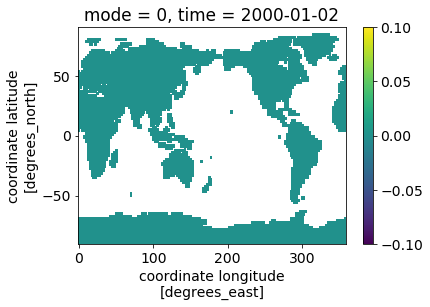

In [25]:
diff.plot()

#### Fraction of variance explained

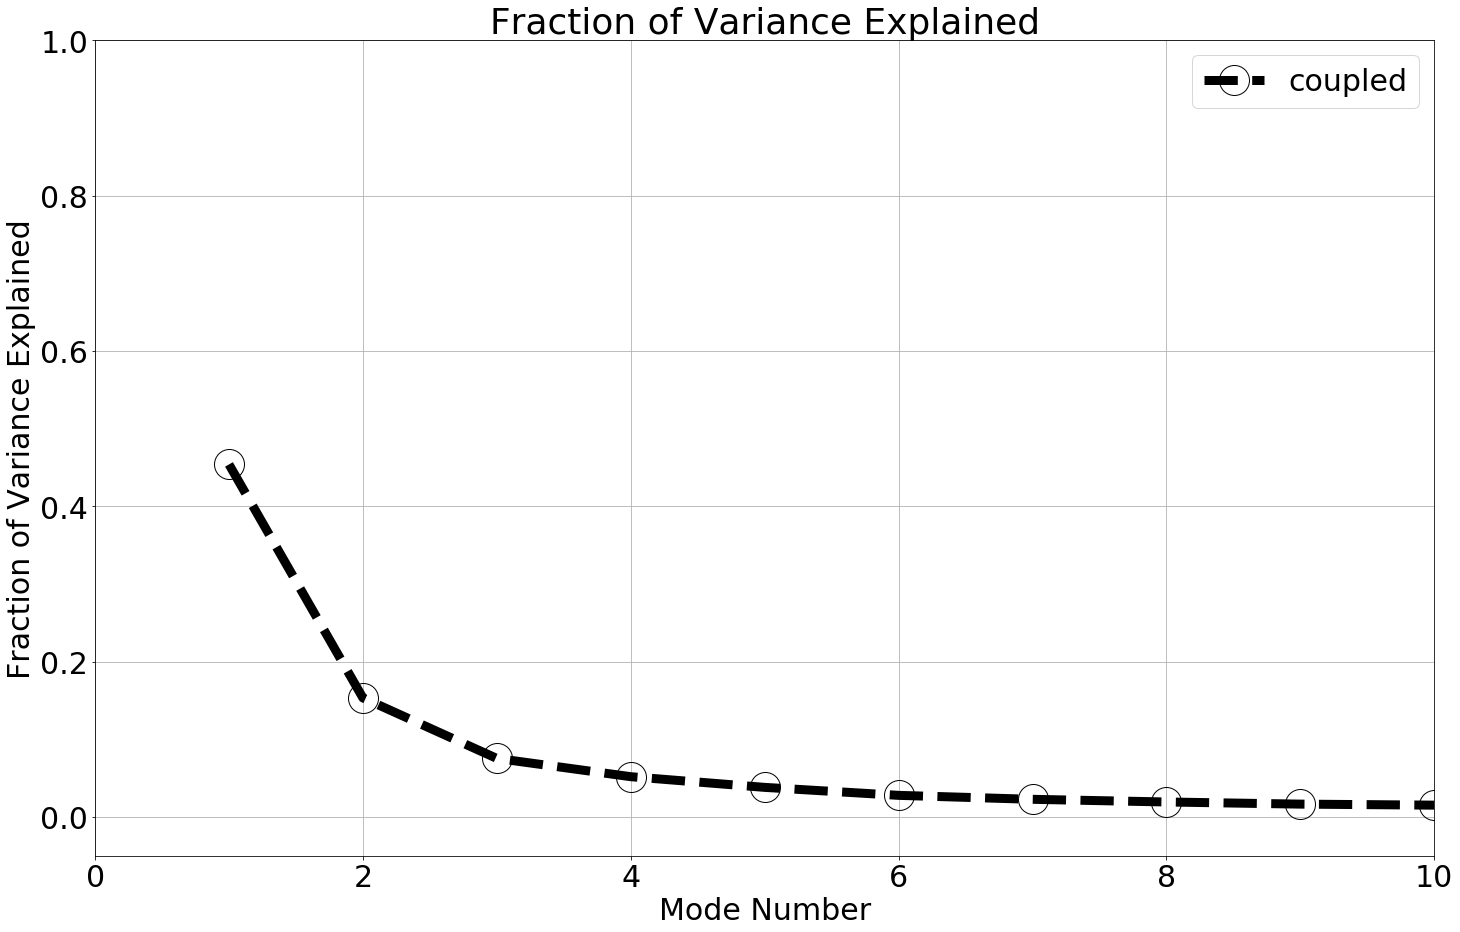

In [18]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(24,15))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,
         'o--k', fillstyle='none',markersize=30,linewidth=9, label=ensemble)
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.ylim([-0.05,1])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.legend()
plt.savefig(var+'_frac_variance_explained.png')

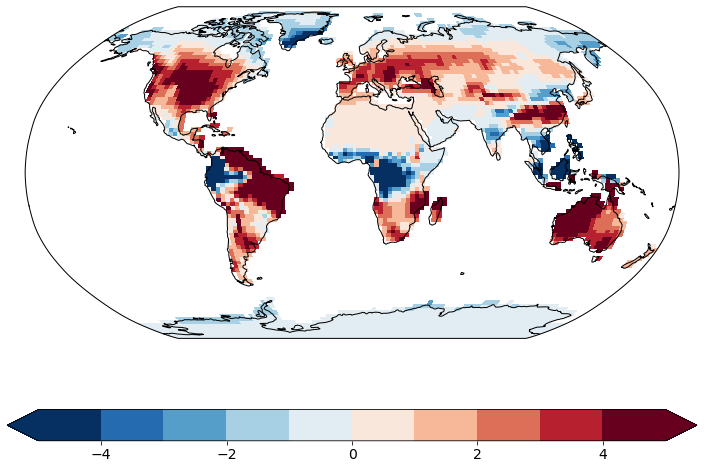

In [22]:
warming_factorPC0_1degreeglobal=1/(eofs[:,:,0]).mean(dim=['lat','lon'])
mapdata=eofs[:,:,0]*warming_factorPC0_1degreeglobal/landweights
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata.where(landfrac>0.3), coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("RdBu_r",10), vmin=-5, vmax=5, #levels=np.arange(-2.0,2.1,0.4), #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-2.0,2.1,0.4))
plt.tight_layout()